# PRÁCTICA GUIADA: Naive Bayes

## Introducción

En esta práctica vamos a implementar un clasificador de tipo Naive Bayes utilizando la biblioteca scikit-learn.

Cada término de NaiveBayes representa la probabilidad de ser de determinada clase dado determinado valor del feature $X_{k}$. 
En el caso de la clasificación de un texto, lo que se mide es la probabilidad de que el texto sea de determinada clase dada la aparición o no de determinada palabra. La productoria de todas estas probabilidades es la probabilidad final de pertenecer a la clase.  

Lo que diferencia a cada algoritmo de Naive Bayes, es la distribución que asumen para el proceso generador de cada una de las clases. En sklearn tenemos:
1. GaussianNaiveBayes
2. MultinomialNaiveBayes
3. BernoulliNaiveBayes


## Gaussian Naive Bayes

Generamos clases a partir de una distribución Gaussiana. 


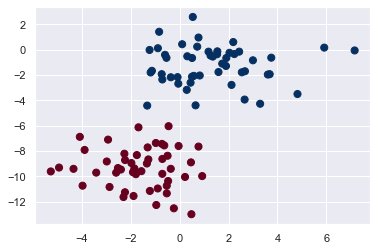

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs


X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Vamos a aplicar a este conjunto de datos un modelo de tipo Gaussian Naive Bayes.

In [2]:
# Ajustamos el modelo con los datos generados
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X, y);

¿Por qué no hicimos validación cruzada sobre el train set en este caso?

In [3]:
# -6 y -14 son los límites inferiores de los datos generados por la función make_blobs
# 14 y 18 son los rangos que ocupan cada una de las variables generadas
# Queremos generar un espacio de puntos que cubra toda el área de los datos originales.

rng = np.random.RandomState(0)
X_nueva = [-6, -14] + [14, 18] * rng.rand(2000, 2)
y_predicha = model.predict(X_nueva)

¿Por qué no hicimos train test split?

A continuación vemos la clasificación que define el modelo sobre todo el espacio de datos, descripto por los 2000 puntos generados más arriba. 


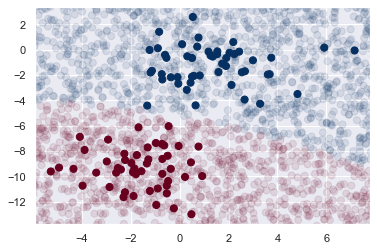

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(X_nueva[:, 0], X_nueva[:, 1], c=y_predicha, s=50, cmap='RdBu', alpha=0.1)
plt.axis(lim);

En el gráfico anterior se observa el "decision boundary" del modelo que surge a partir de suponer una distribución Gaussiana sobre cada una de las clases en los datos de entrenamiento. <br>

### Cálculo de probabilidades

Una de las ventajas de este modelo es que nos permite obtener para cada punto del dominio, la probabilidad de pertenecer a una u otra clase.

In [5]:
yprob = model.predict_proba(X_nueva)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])


## Clasificación de texto

Para el siguiente ejemplo vamos a descargar el dataset 20 newsgroup que contiene correos electrónicos solicitando información a distintos medios digitales acerca de distintos tópicos.

Para más información del dataset pueden consultar: http://qwone.com/~jason/20Newsgroups/

#### Importamos los datos

In [6]:
from sklearn.datasets import fetch_20newsgroups

mis_datos = fetch_20newsgroups()
type(mis_datos)

sklearn.utils.Bunch

In [7]:
# Exploramos el objeto y vemos que el dataframe no tiene nombres de columnas
mis_datos.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [8]:
print(type(mis_datos.data),'El corpus de textos es una lista')
print(type(mis_datos.data[0]),'Cada elemento de la lista es un string')

<class 'list'> El corpus de textos es una lista
<class 'str'> Cada elemento de la lista es un string


In [9]:
# Veamos el primer texto del corpus
print(mis_datos.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [10]:
# Veamos ahora en qué clases se dividen los datos

mis_datos.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

#### Split train-test y simplificación del dataframe

Para facilitar el problema de clasificación vamos a quedarnos únicamente con algunas de las categorías que contienen los datos. La clase Bunch tiene un método especialmente diseñado para esto:


In [11]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']

train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [12]:
len(train.data)

2153

In [13]:
len(test.data)

1432

#### Feature Engeneering

Para poder implementar un modelo predictivo necesitamos transformar cada uno de los documentos de texto que pertenecen al corpus en una matriz de features.

Para esto, vamos a utilizar el algoritmo de scikit-learn `TfidfVectorizer()`. Este algoritmo busca vectorizar un corpus de textos contando en cada documento la ocurrencia de cada palabra. Primero se buscan todas las palabras que existen en el corpus y luego se computa la cantidad de veces que aparecen en cada documento. Este proceso se denomina "word count".

El problema de este enfoque es existen palabras que aparecen con mucha frecuencia en un texto pero aportan poco valor para la clasificación: palabras como "la", "lo" ó "del" se espera que aparezcan muchas veces en todos los documentos. 

Lo que hace TfidfVectorizer() es calcular la frecuencia de la aparición de un término en un docuemnto ponderada por la aparición en el resto del corpus para darle mayor peso a los términos que distinguen a cada documento de los otros.

Más información en http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
y para los detalles de implementación: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [14]:
# Generamos el modelo y lo aplicamos a los datos de entrenamiento

from sklearn.feature_extraction.text import TfidfVectorizer
modelo_tfidf = TfidfVectorizer()
X_train = modelo_tfidf.fit_transform(train.data)

In [15]:
# Veamos la transformación que se hizo sobre los datos
print(len(train.data))
print(X_train.shape)

2153
(2153, 35329)


In [16]:
# Veamos qué tipo de datos contiene X
type(X_train)

scipy.sparse.csr.csr_matrix

In [17]:
# La matriz dispersa sólo conserva los valores distintos de 0.
X_train.size

352179

In [18]:
# Cuando transformamos la matriz en array, la cantidad de elementos se multiplica varias veces
X_train.toarray().size

76063337

In [19]:
# Veamos los primeros y últimos features que construyó el modelo
modelo_tfidf.get_feature_names()[0:30]

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000021',
 '000062david42',
 '0000vec',
 '0001',
 '000100255pixel',
 '00041032',
 '0004136',
 '0004246',
 '0004422',
 '00044513',
 '0004847546',
 '0005',
 '0007',
 '00090711',
 '000usd',
 '0010580b',
 '0012',
 '001200201pixel',
 '0014',
 '001428',
 '001555',
 '001718',
 '001757',
 '0018']

In [20]:
modelo_tfidf.get_feature_names()[-30:]

['zoro',
 'zoroaster',
 'zoroastrian',
 'zoroastrianism',
 'zoroastrians',
 'zowie',
 'zrz',
 'zsoft',
 'zt',
 'zubin',
 'zuck',
 'zug',
 'zullen',
 'zulu',
 'zurbrin',
 'zurich',
 'zurvanism',
 'zvi',
 'zwaartepunten',
 'zwak',
 'zwakke',
 'zware',
 'zwart',
 'zwarte',
 'zxmkr08',
 'zyeh',
 'zyxel',
 'ªl',
 'º_________________________________________________º_____________________º',
 'ºnd']

#### Entrenamiento de un clasificador Naive Bayes

Con la matriz construída para los datos de entrenamiento vamos a entrenar un clasificador utilizando el modelo MultinomialNaiveBayes()

In [21]:
from sklearn.naive_bayes import MultinomialNB
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train, train.target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Predicción

Con los parámetros del modelo calculados, vamos a predecir sobre los datos de prueba. 
¿Cómo vectorizamos los datos de test? ¡Tenemos que utilizar el modelo tf-idf con el que habíamos transformado los datos de entrenamiento!



In [22]:
X_test = modelo_tfidf.transform(test.data)

In [23]:
# También se genera una sparse matrix
type(X_test)

scipy.sparse.csr.csr_matrix

In [24]:
# Con los features de test transformados calculamos las labels predichas
labels_predichas = modelo_NB.predict(X_test)

In [25]:
labels_predichas

array([2, 0, 1, ..., 1, 2, 1], dtype=int64)

In [26]:
# Las labels están asociadas a las etiquetas del objeto Bunch original
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

#### Matriz de confusión

A continuación graficamos una matriz de confusión entre lo predicho y las verdaderas labels en test

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Primero calculamos el accuracy general del modelo
from sklearn.metrics import accuracy_score
accuracy_score(test.target, labels_predichas)

0.8016759776536313

In [29]:
# Ahora calculamos la matriz de confusión
mat = confusion_matrix(test.target, labels_predichas)
mat.shape

(4, 4)

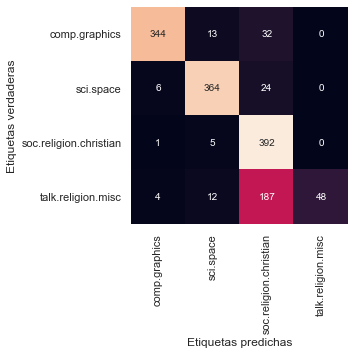

In [30]:
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas');

#### Conclusión

Incluso con un modelo muy simple como Naive Bayes, podemos clasificar un corpus de texto con bastante precisión.

En la matriz de confusión podemos observar algo que era esperable: los correos sobre religión en general se confunden con los correos sobre religión cristiana específicamente ya que usan un vocabulario similar.

Una cosa interesante a tener en cuenta es que ahora tenemos un clasificador de strings. Podemos pasarle cualquier string y clasificarlo de forma automática. Obviamente, tendremos que hacerlo en inglés. Solamente encapsulemos todo en una función:

In [31]:
def predict_category(s,train=train):
    x = modelo_tfidf.transform([s]) # llamamos al vectorizador que usamos (tiene que ser el mismo)
    pred = modelo_NB.predict(x) # hacemos el predict, usando el modelo que fiteamos.
    return train.target_names[pred[0]] # devolvemos la categoría que corresponde a la predicción

Probemos:

In [32]:
predict_category('sending a payload to the ISS')

'sci.space'

In [33]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [34]:
predict_category('determining the screen resolution')

'comp.graphics'

Recordemos que esto no es nada sofisticado: es simplemente un modelo probabilístico (bastante simple en sus supuestos) para la frecuencia poderada de cada palabra en un string. No obstante, obtenemos un accuarcy bastante razonable. 